In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import pyIGRF
import cProfile, pstats, io
%matplotlib inline

In [5]:
# Set the following parameters to determine which stations have "good" availability

syear = 1995  # Good stations will only be identified based on info between syear and eyear
eyear = 2019
'''Solar Maxima: 2002, 2014
   Solar Minima: 1997, 2009, 2020'''
low_lat = -90. # The minimum geographic latitude of stations to be considered
high_lat = 90. # The maximum geographic latitude of stations to be considered
w_lon = -180. # The minimum geographic longitude of stations to be considered
e_lon = 180. # The maximum geographic latitude of stations to be considered
avg_avail_min = 0 # Stations whose average percent available data over the years of consideration are less than this are eliminated
year_avail_min =0  # Stations that don't have at least this much available data every year are eliminated
all_stations_path = "supermag_table.csv" # The path to your raw SuperMAG data table
all_stations = pd.read_csv(all_stations_path)
all_stations["GLongg"] = all_stations["GLON"].apply(lambda x: x - 360 if x > 180 else x)

In [3]:
# Run the previous cell before running this one!



year_range = np.arange(syear, eyear+1)

if w_lon > e_lon:
    w_lon -= 360
    
# Select only the relevant years
all_cols = all_stations.columns.values
to_drop = []
for col_num in range(6, len(all_stations.iloc[1])):
    if int(all_cols[col_num]) not in year_range:
        to_drop.append(all_stations.columns[col_num])
all_stations = all_stations.drop(to_drop, axis=1)

# Select only the stations in the relevant region
outside_stations = []
for station in range(len(all_stations)):
    row = all_stations.iloc[station]
    if row["GLAT"] < low_lat or row["GLAT"] > high_lat or row["GLON"] < w_lon or row["GLON"] > e_lon:
        outside_stations.append(station)
geo_stations = all_stations.drop(outside_stations)

# Select only the stations with average availability >= avail_min
good_stations = pd.DataFrame([])
for row_num in range(len(geo_stations)):
    new_row = geo_stations.iloc[row_num][:6]
    pcts = []
    for col_num in range(6, len(geo_stations.iloc[1])):
        pct_str = geo_stations.iloc[row_num][col_num]
        pct = float(pct_str[:-1])
        pcts.append(pct)
    if np.sum(pcts) > avg_avail_min*(len(geo_stations.iloc[1])-6) and np.size(np.where(np.array(pcts)<year_avail_min)) == 0:
        new_row = pd.concat([new_row, pd.DataFrame(pcts)])
        good_stations = pd.concat([good_stations, new_row], axis=1, ignore_index=True)


print(good_stations.loc["IAGA"].values)
print(f"{len(good_stations.loc['IAGA'].values)} stations")

ValueError: invalid literal for int() with base 10: 'GLongg'

-180.0


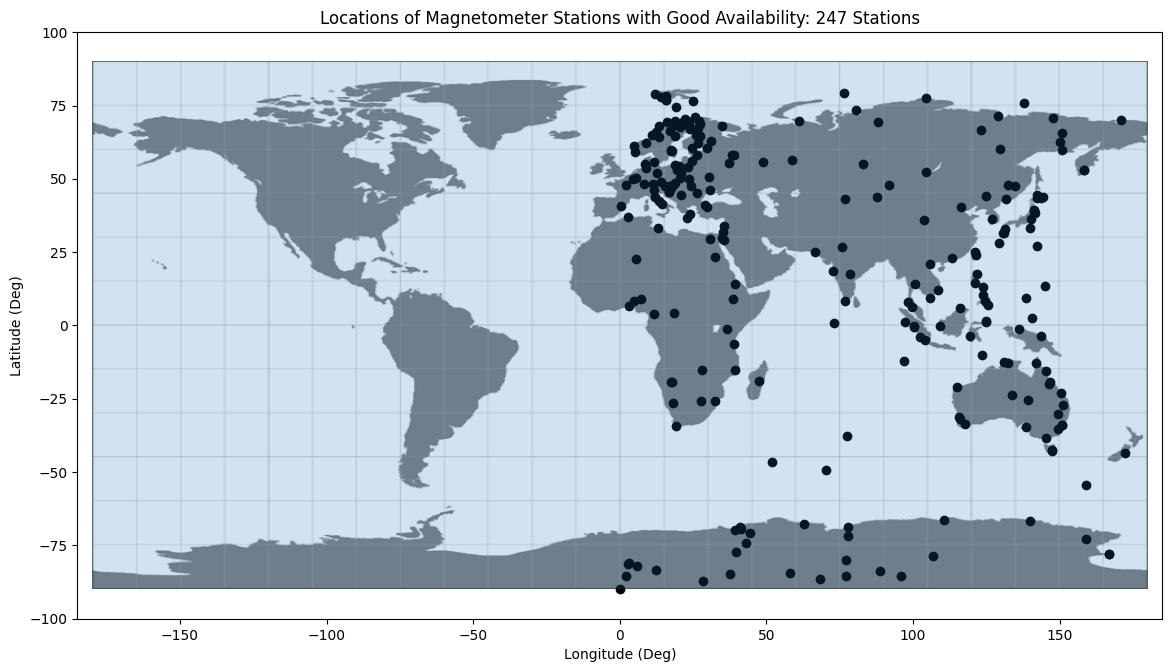

In [25]:
# Run the previous cells before running this one!

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(14,14))
img=mpimg.imread('world_map.jpg')
ax.imshow(img, extent=[-180,180,-90,90])

print(w_lon)
if w_lon >= 180:
    w_lon -= 360
    e_lon -= 360
    
lats = good_stations.loc["GLAT"].values
lons = good_stations.loc["GLON"].values
for i in range(len(lons)):
    if lons[i] >= 180:
        lons[i] -= 360

        
ax.scatter(lons, lats, c="Black")
ax.add_patch(Rectangle((w_lon, low_lat), e_lon-w_lon, high_lat-low_lat, alpha=0.2))
ax.set_xlim(w_lon-5,e_lon+5)
ax.set_ylim(low_lat-10, high_lat+10)
plt.xlabel("Longitude (Deg)")
plt.ylabel("Latitude (Deg)")
plt.title(f"Locations of Magnetometer Stations with Good Availability: {len(lats)} Stations")
plt.savefig("good_locs.png")

In [34]:
# @jit(nopython=True)

def calculateMag(xspace, yspace, year, height):
    euator = np.zeros((len(xspace), 2))
    inclination = np.zeros((len(yspace), len(xspace)))
    magnt = np.zeros((len(yspace), len(xspace)))
    for x in range(len(xspace)):
        for y in range(len(yspace)):
            decl, inc, hMag, xMag, yMag, zMag, fMAg = pyIGRF.igrf_value(yspace[y], xspace[x], height, year)
            inclination[y,x] = inc
            magnt[y,x] = fMAg



    
    equator = []
    for ii in range(inclination.shape[1]):
        
        temp = inclination[:,ii]

        sts = np.where((temp > -1) & (temp < 1))
        # print(sts)

        idx = sts[0][np.argmin(abs(temp[sts]))]


        equator.append(yspace[idx])    

    return inclination, equator, magnt

In [35]:
# pr = cProfile.Profile()
# pr.enable()
xspace = np.arange(-180,181,0.5)
yspace = np.arange(-90,91, 0.5)
incl, euator, magnt = calculateMag(xspace, yspace, 2022., 100)
# pr.disable()

In [36]:
high_lats = all_stations[(abs(all_stations["MLAT"])>=60) & (abs(all_stations["MLAT"])<90)]
mid_lats = all_stations[(abs(all_stations["MLAT"])>=30) & (abs(all_stations["MLAT"])<60)]
low_lats = all_stations[(abs(all_stations["MLAT"])>=0) & (abs(all_stations["MLAT"])<30)]


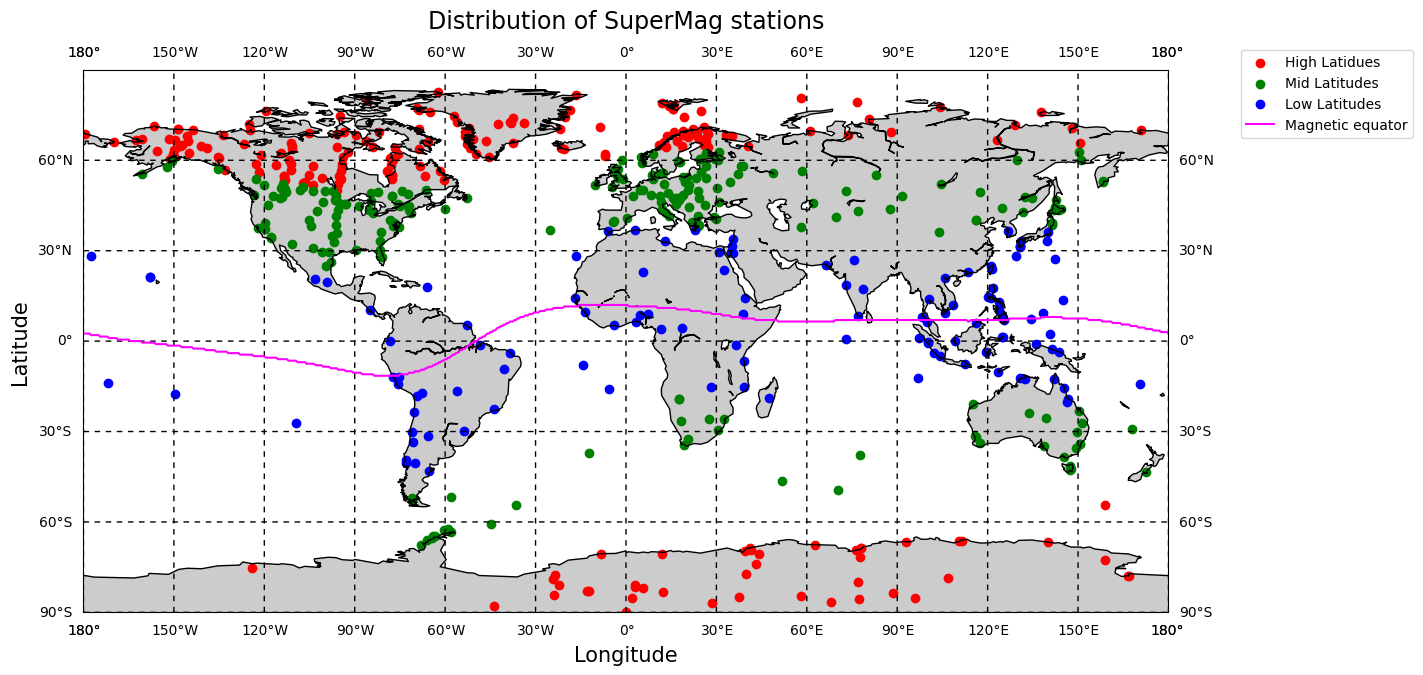

In [37]:
# Run the previous cells before running this one!
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle


fig, ax = plt.subplots(figsize=(14,14))
# img=mpimg.imread('world_map.jpg')
# ax.imshow(img, extent=[-180,180,-90,90])
m = Basemap()
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black')
m.fillcontinents()
m.drawmeridians(range(0, 360, 30), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 1, 1])
m.drawparallels(range(-90, 90, 30), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 1, 0, 0])
# m.drawcountries()




# print(w_lon)
# if w_lon >= 180:
#     w_lon -= 360
#     e_lon -= 360

# for i in range(len(lons)):
#     if lons[i] >= 180:
#         lons[i] -= 360


# ax.scatter(all_stations["GLongg"].values, all_stations["GLAT"].values, c="red")
ax.scatter(high_lats["GLongg"].values, high_lats["GLAT"].values, c="red", label="High Latidues")
ax.scatter(mid_lats["GLongg"].values, mid_lats["GLAT"].values, c="green", label="Mid Latitudes")
ax.scatter(low_lats["GLongg"].values, low_lats["GLAT"].values, c="blue", label="Low Latitudes")
ax.plot(xspace,euator, color="magenta",label="Magnetic equator")

ax.legend(bbox_to_anchor=(1.06, 1.05))# ax.set_xlim(-180,180)
# ax.set_ylim(-90, 90)
plt.ylabel("Latitude", fontsize=15, labelpad=35)
plt.xlabel("Longitude", fontsize=15, labelpad=20)

# plt.xlabel("Longitude (Deg)")
# plt.ylabel("Latitude (Deg)")
plt.title(f"Distribution of SuperMag stations", fontsize=17, pad=30)
plt.savefig("good_locs.png", bbox_inches='tight')

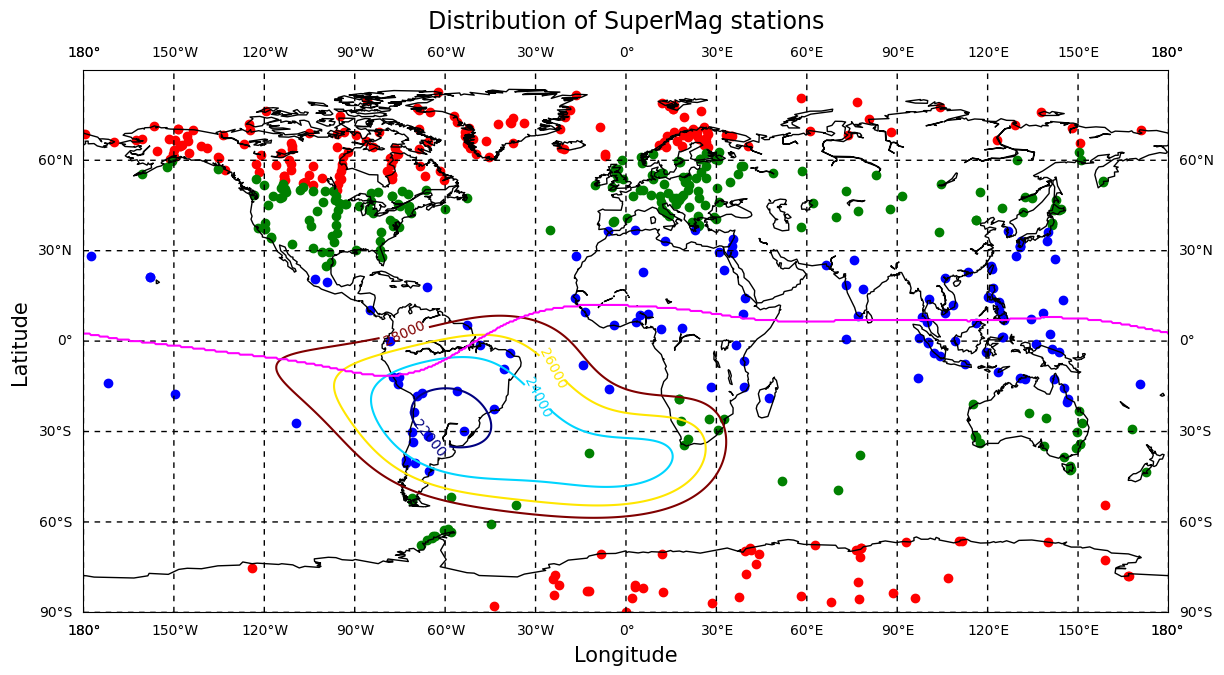

In [53]:
# Run the previous cells before running this one!
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle


fig, ax = plt.subplots(figsize=(14,14))
# img=mpimg.imread('world_map.jpg')
# ax.imshow(img, extent=[-180,180,-90,90])


m = Basemap()
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black')
# m.fillcontinents()
m.drawmeridians(range(0, 360, 30), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 1, 1])
m.drawparallels(range(-90, 90, 30), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 1, 0, 0])
# m.drawcountries()




# print(w_lon)
# if w_lon >= 180:
#     w_lon -= 360
#     e_lon -= 360

# for i in range(len(lons)):
#     if lons[i] >= 180:
#         lons[i] -= 360
# ax.legend(bbox_to_anchor=(1.06, 1.05))# ax.set_xlim(-180,180)
# ax.set_ylim(-90, 90)
levels = np.arange(22000,30000,2000)
# levels = np.arange(22000, 30000, 40000)
CS = ax.contour(xspace, yspace,magnt, levels=levels, cmap='jet')
# manual_locations = [
#     (21000, 24000)]
ax.clabel(CS, inline=True, fontsize=10)#, manual=manual_locations)
# ax.scatter(all_stations["GLongg"].values, all_stations["GLAT"].values, c="red")
ax.scatter(high_lats["GLongg"].values, high_lats["GLAT"].values, c="red", label="High Latidues")
ax.scatter(mid_lats["GLongg"].values, mid_lats["GLAT"].values, c="green", label="Mid Latitudes")
ax.scatter(low_lats["GLongg"].values, low_lats["GLAT"].values, c="blue", label="Low Latitudes")
ax.plot(xspace,euator, color="magenta",label="Magnetic equator")



plt.ylabel("Latitude", fontsize=15, labelpad=35)
plt.xlabel("Longitude", fontsize=15, labelpad=20)

# plt.xlabel("Longitude (Deg)")
# plt.ylabel("Latitude (Deg)")
plt.title(f"Distribution of SuperMag stations", fontsize=17, pad=30)
plt.savefig("good_locs.png", bbox_inches='tight')

In [97]:
pixel_size = 2

lng_1darray = np.arange(0, 360, pixel_size)
lat_1darray = np.arange(180, 0, -pixel_size)

lngs, lats = np.meshgrid(lng_1darray, lat_1darray)

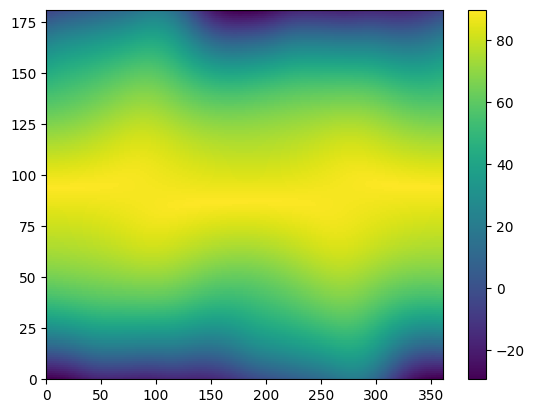

In [94]:
plt.pcolormesh(np.transpose(incl[0]))
plt.colorbar()